In [1]:
# !pip install --upgrade google-auth google-auth-oauthlib google-auth-httplib2
# !pip install -U seaborn matplotlib pandas numpy scipy

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install pyreadstat

#!sudo apt-get remove fonts-nanum

In [3]:
import seaborn as sns
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.font_manager as fm

tf.keras.utils.set_random_seed(124)
tf.config.experimental.enable_op_determinism()
#한글처리
matplotlib.pyplot.rc('font',family='NanumBarunGothic')
matplotlib.pyplot.rcParams['axes.unicode_minus']=False

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fulldata_05_18_01_P_미용업.csv', encoding='cp949')
df=df[['인허가일자','폐업일자','상세영업상태코드','업태구분명','사용시작지상층','의자수','좌표정보(x)','좌표정보(y)']]
df.head()

<ipython-input-3-d3617654d10c>:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fulldata_05_18_01_P_미용업.csv', encoding='cp949')


,인허가일자,폐업일자,상세영업상태코드,업태구분명,사용시작지상층,의자수,좌표정보(x),좌표정보(y)
0,2022-05-17,2022-08-03,2,네일아트업,0.0,3.0,217750.864735,448205.881995
1,2022-05-19,2022-07-13,2,일반미용업,1.0,4.0,175829.096963,446208.270588
2,2022-05-19,2023-02-09,2,일반미용업,0.0,2.0,190049.611824,442823.529335
3,2022-05-23,2022-07-27,2,네일아트업,1.0,1.0,230485.827493,314852.264619
4,2022-05-23,2022-08-04,2,네일아트업,0.0,2.0,184933.093703,423266.254567


<Axes: >

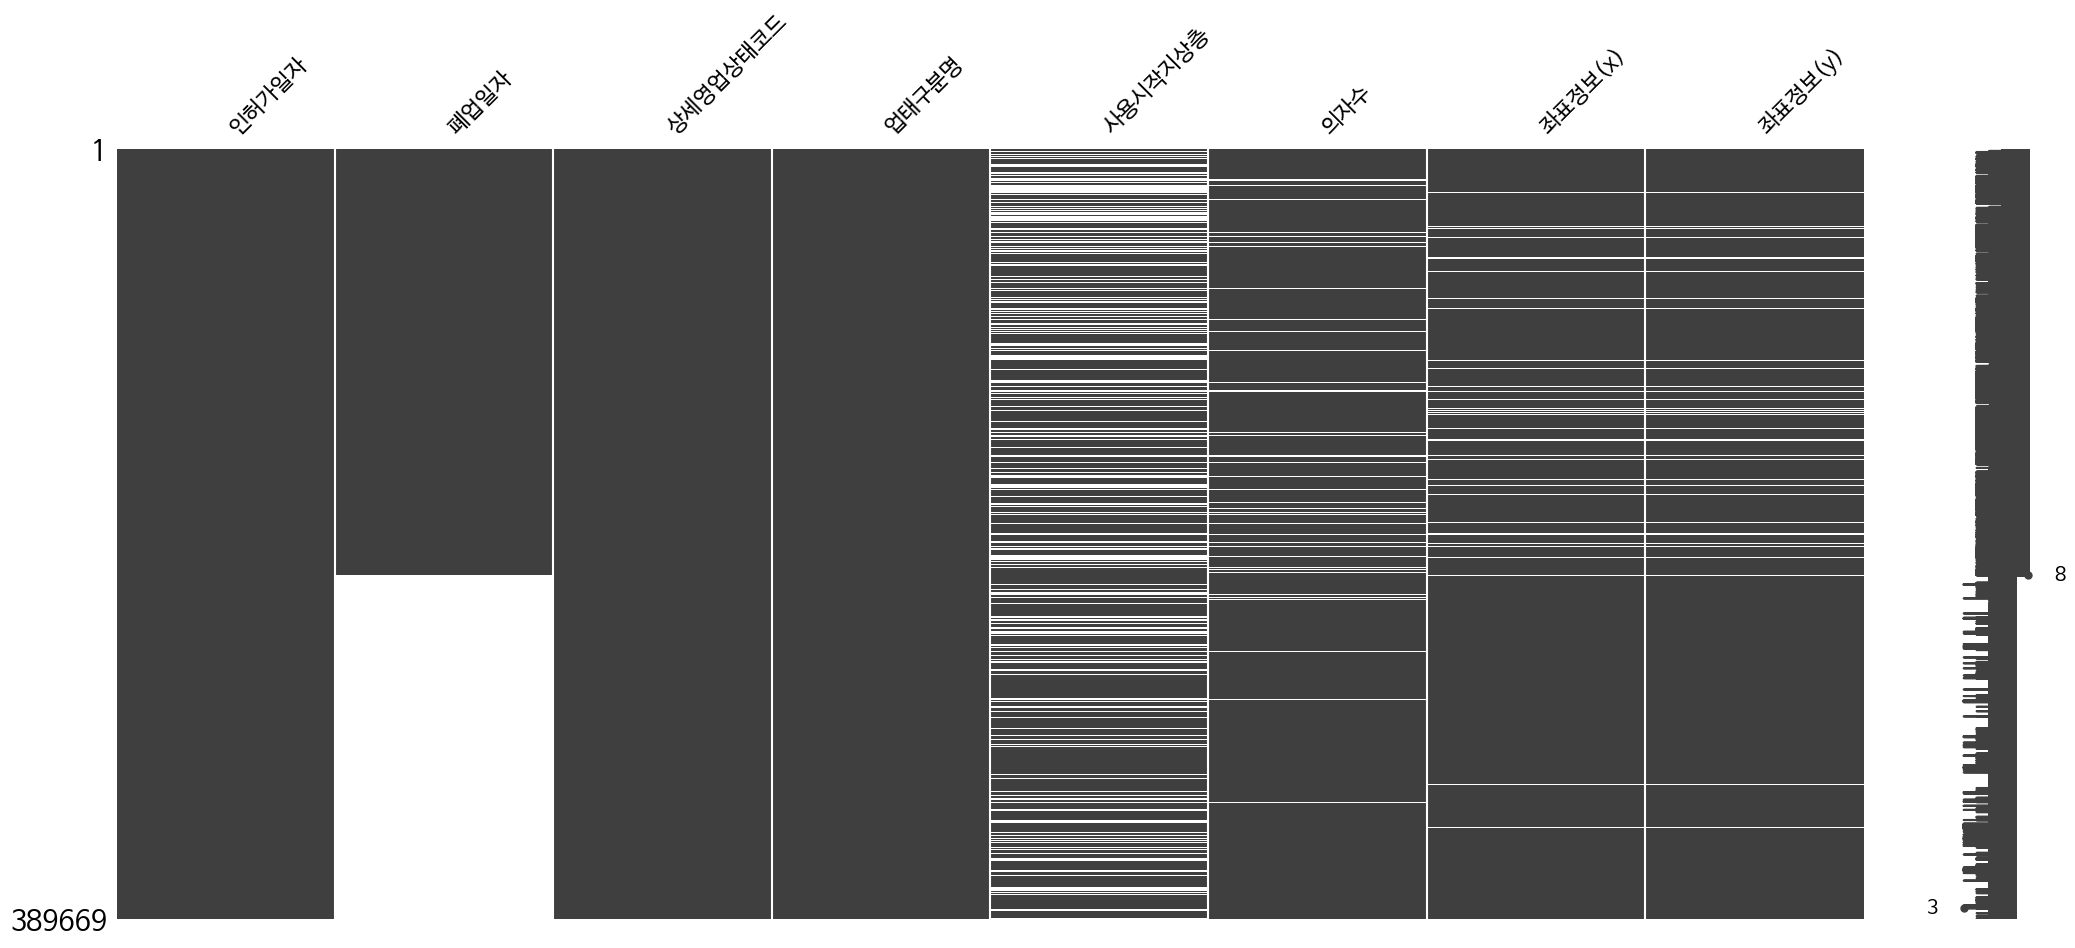

In [4]:
import missingno as msno
msno.matrix(df)
#데이터의 특성:시계열,범주형,인트형,플롯형이 골골루 섞여있습니다.

In [5]:
df.dropna(subset=['사용시작지상층'], inplace=True)
df.dropna(subset=['의자수'], inplace=True)
df.dropna(subset=['좌표정보(x)'], inplace=True)
df.dropna(subset=['좌표정보(y)'], inplace=True)

<Axes: >

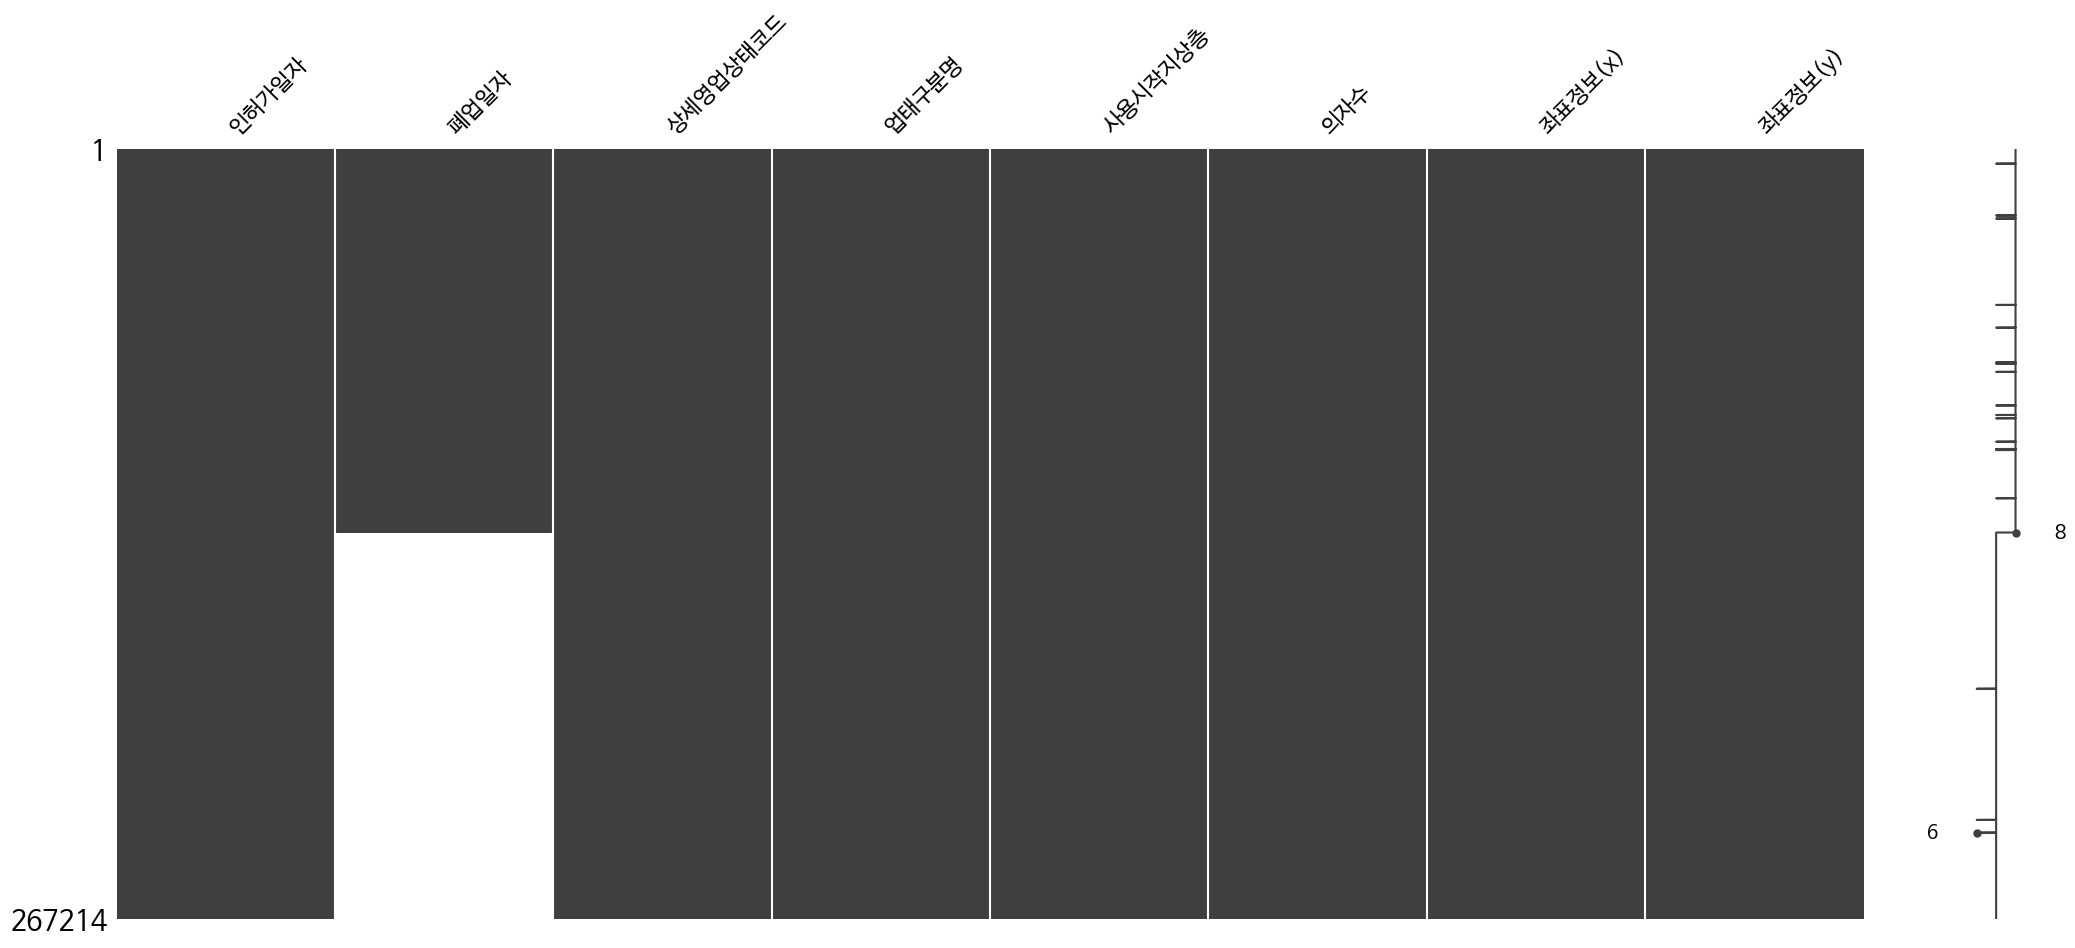

In [6]:
import missingno as msno
msno.matrix(df)

In [7]:
from datetime import datetime
df['인허가일자'] = df['인허가일자'].astype(str)
df['폐업일자'] = df['폐업일자'].astype(str)

df['인허가일자'] = df['인허가일자'].str.replace('00', '01')
df['인허가일자'] = df['인허가일자'].str.replace('2010-02-29', '2010-02-28')
df['인허가일자'] = df['인허가일자'].str.replace('2018-02-29', '2018-02-28')

df['폐업일자'] = df['폐업일자'].str.replace('2006-02-29', '2006-02-28')
df['폐업일자'] = df['폐업일자'].str.replace('2011-02-29', '2011-02-28')
df['폐업일자'] = df['폐업일자'].str.replace('2003-02-30', '2003-02-28')
df['폐업일자'] = df['폐업일자'].str.replace('2002-02-29', '2002-02-28')

# '인허가일자'와 '폐업일자' 컬럼을 datetime 형식으로 변환
df['인허가일자'] = pd.to_datetime(df['인허가일자'])
df['폐업일자'] = pd.to_datetime(df['폐업일자'])

# 두 날짜의 차이 계산하여 '날짜차이' 컬럼 생성
df['날짜차이'] = df['폐업일자'] - df['인허가일자']
df['날짜차이_변환'] = df['날짜차이'].apply(lambda x: x.total_seconds() / (24 * 60 * 60))
df['날짜차이_변환'] = abs(df['날짜차이_변환'])

In [8]:
today = pd.Timestamp.today().normalize()
for col in df.columns:
    if df['폐업일자'].dtype == 'datetime64[ns]':
        df['폐업일자'] = df['폐업일자'].replace(pd.NaT, today)

In [9]:
# 두 날짜의 차이 계산하여 '날짜차이' 컬럼 생성
df['날짜차이'] = df['폐업일자'] - df['인허가일자']
df['날짜차이_변환'] = df['날짜차이'].apply(lambda x: x.total_seconds() / (24 * 60 * 60))
df['날짜차이_변환'] = abs(df['날짜차이_변환'])

In [10]:
#원-핫-인코딩
onehot_upte=pd.get_dummies(df['업태구분명'])
df=pd.concat([df,onehot_upte],axis=1)
df.head()

,인허가일자,폐업일자,상세영업상태코드,업태구분명,사용시작지상층,의자수,좌표정보(x),좌표정보(y),날짜차이,날짜차이_변환,기타,네일아트업,메이크업업,미용업 기타,숙박업 기타,일반미용업,일반이용업,피부미용업
0,2022-05-17,2022-08-03,2,네일아트업,0.0,3.0,217750.864735,448205.881995,78 days,78.0,0,1,0,0,0,0,0,0
1,2022-05-19,2022-07-13,2,일반미용업,1.0,4.0,175829.096963,446208.270588,55 days,55.0,0,0,0,0,0,1,0,0
2,2022-05-19,2023-02-09,2,일반미용업,0.0,2.0,190049.611824,442823.529335,266 days,266.0,0,0,0,0,0,1,0,0
3,2022-05-23,2022-07-27,2,네일아트업,1.0,1.0,230485.827493,314852.264619,65 days,65.0,0,1,0,0,0,0,0,0
4,2022-05-23,2022-08-04,2,네일아트업,0.0,2.0,184933.093703,423266.254567,73 days,73.0,0,1,0,0,0,0,0,0


In [11]:
#필요한 컬럼만 다시 데이터 프레임에 담기
df=df[['상세영업상태코드','사용시작지상층','의자수','좌표정보(x)','좌표정보(y)',
       '날짜차이_변환','기타','네일아트업','메이크업업','미용업 기타',
       '숙박업 기타','일반미용업','일반이용업','피부미용업']]
df['사용시작지상층'] = df['사용시작지상층'].replace(0.0, 1.0)
df['의자수'] = df['의자수'].replace(0.0, 1.0)
s7=df.loc[df.index == 276352] #대구광역시 중구 동인동4가 임의의 좌표추출(2차전 준비)

<Axes: >

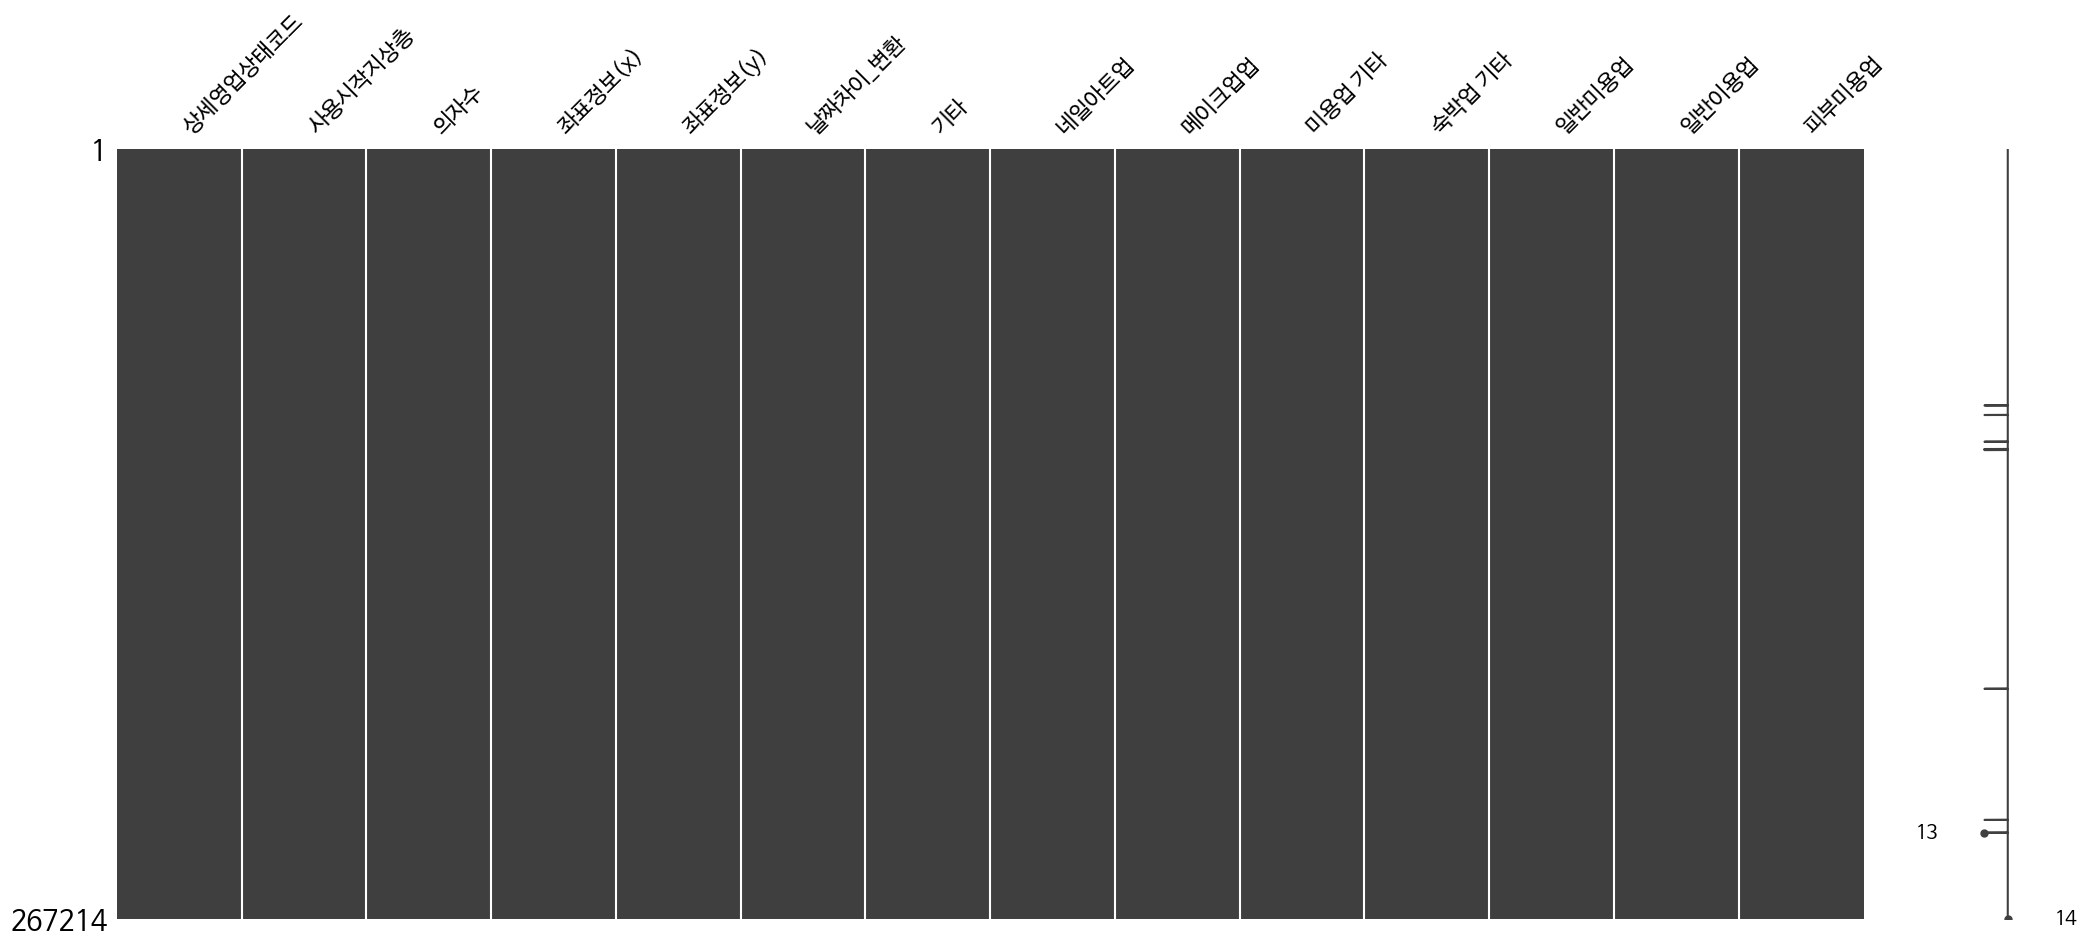

In [12]:
msno.matrix(df)

In [13]:
#이상치로 버려는 데이터-많은 수의 데이터로 학습하면, 이상치가 이상치가 아니지만 시간이 많이 걸리고,
#그래서 10만개를 기준으로 3D 그래프로 표현했을때, 과하게 분포들이 점유하지 않은값을 선택했습니다.
df = df[df['날짜차이_변환'] <= 30000]
df = df[df['사용시작지상층'] <= 25]#미용실이 위치한 층수
df = df[df['의자수'] <= 40]#미용실이 보유한 의자수

#100000개 랜덤하게 추출해서 이후의 자료로 사용함.
import random
df = df.sample(n=100000, random_state=1)
df.head()

,상세영업상태코드,사용시작지상층,의자수,좌표정보(x),좌표정보(y),날짜차이_변환,기타,네일아트업,메이크업업,미용업 기타,숙박업 기타,일반미용업,일반이용업,피부미용업
231070,1,1.0,2.0,177930.616705,444812.126350,224.0,0,0,1,0,0,0,0,0
225828,1,2.0,4.0,202029.981800,455605.716911,14243.0,0,0,0,0,0,1,0,0
263060,1,2.0,10.0,354846.203322,341885.836712,3237.0,0,0,0,0,0,1,0,0
255145,1,2.0,4.0,205996.639125,442966.118103,1404.0,1,0,0,0,0,0,0,0
97501,2,1.0,1.0,192920.500639,402594.899210,613.0,0,0,0,0,0,0,0,1


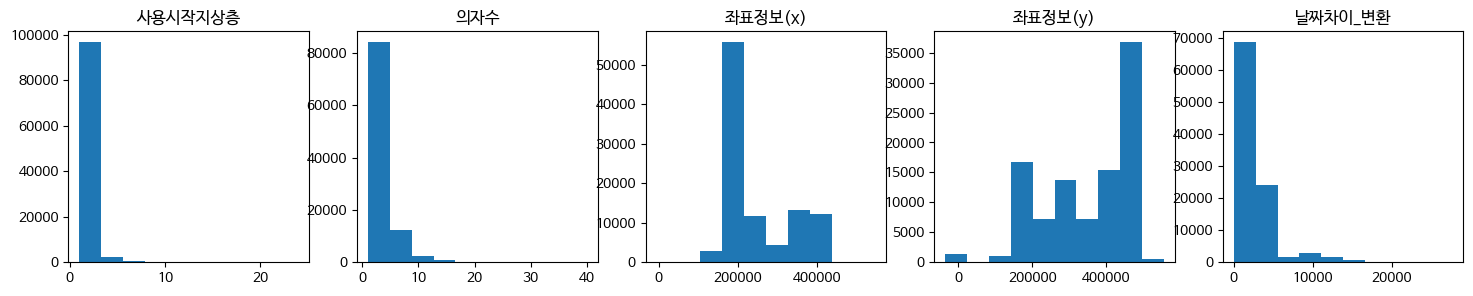

In [14]:
#중간 결과를 알기 위해서 필요한 시각화
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18, 3)
fig, axs = plt.subplots(1, 5)
axs[0].hist(df['사용시작지상층'])
axs[0].set_title('사용시작지상층')
axs[1].hist(df['의자수'])
axs[1].set_title('의자수')
axs[2].hist(df['좌표정보(x)'])
axs[2].set_title('좌표정보(x)')
axs[3].hist(df['좌표정보(y)'])
axs[3].set_title('좌표정보(y)')
axs[4].hist(df['날짜차이_변환'])
axs[4].set_title('날짜차이_변환')
plt.show()
#어떤 데이터 처리 방법이 적합할까요? 
#KMeans(군집)을 선택합니다.

In [15]:
X=df[['사용시작지상층','의자수','좌표정보(x)','좌표정보(y)','상세영업상태코드',
      '날짜차이_변환','기타','네일아트업','메이크업업','미용업 기타',
      '숙박업 기타','일반미용업','일반이용업','피부미용업']]

#표준화(Standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['사용시작지상층','의자수','좌표정보(x)','좌표정보(y)','상세영업상태코드',
    '날짜차이_변환','기타','네일아트업','메이크업업','미용업 기타',
    '숙박업 기타','일반미용업','일반이용업','피부미용업']] = scaler.fit_transform(X)

#정규화(Normalization)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['사용시작지상층','의자수','좌표정보(x)','좌표정보(y)','상세영업상태코드',
    '날짜차이_변환','기타','네일아트업','메이크업업','미용업 기타',
     '숙박업 기타','일반미용업','일반이용업','피부미용업']] = scaler.fit_transform(X)

X=df[['사용시작지상층','의자수','좌표정보(x)','좌표정보(y)','상세영업상태코드',
      '날짜차이_변환','기타','네일아트업','메이크업업','미용업 기타',
      '숙박업 기타','일반미용업','일반이용업','피부미용업']].values

In [16]:
#하이퍼파라이터 셋팅(10분 걸림)
from itertools import product
n_clusters_list = [12,15,20,25,30]
init_list = ['k-means++', 'random']
n_init_list = [20]
max_iter_list = [100,300,500]
tol_list = [1e-4,1e-5]
algorithm_list = ['lloyd', 'elkan']
#기본값은 algorithm='auto'로 자동으로 lloyd 알고리즘이나 elkan(변종) 알고리즘 중 하나가 선택
#하지만 이 값은 sklearn 1.3에서는 사용할 수 없으므로, 알고리즘을 선택
random_state_list = [123]
hyperparameters = list(product(n_clusters_list,init_list,n_init_list,max_iter_list,
                                tol_list,algorithm_list,random_state_list))
best_score = None
best_params = None
for params in hyperparameters:
#비지도 학습-클러스터 개수k,labels_인스턴스 변수
    model = KMeans(n_clusters=params[0],init=params[1],n_init=params[2],
                   max_iter=params[3],tol=params[4],algorithm=params[5],
                   random_state=params[6])
    model.fit(X)
    score = model.score(X)
    if best_score is None or score > best_score:
        best_score = score
        best_params = params
print('Best score:', best_score)
print('Best parameters:', best_params)
#최적 베스트 하이퍼파라이터
n_clusters = best_params[0]
init = best_params[1]
n_init = best_params[2]
max_iter = best_params[3]
tol = best_params[4]
algorithm = best_params[5]
random_state = best_params[6]
#ex)Best parameters: (25, 'k-means++', 20, 100, 1e-05, 'lloyd', 123)로이드

Best score: -1837.0463865702077
Best parameters: (30, 'k-means++', 20, 100, 1e-05, 'lloyd', 123)


In [17]:
#inertia:군집 내 거리제곱합의 합(1분)
ks=range(1,best_params[0])
inertias=[]
for k in ks:
    model=KMeans(n_clusters =k,init = best_params[1],n_init = best_params[2],
                 max_iter = best_params[3],tol = best_params[4],
                 algorithm = best_params[5],random_state = best_params[6])
    model.fit(X)
    inertias.append(model.inertia_)
for i in range(len(inertias)):
    print([i],'번째:',inertias[i])
#inertias(이너셔:관성)는 각 클러스터 내 데이터 포인트와 해당 클러스터의 중심 사이의 거리를 제곱하여 합한 값

[0] 번째: 82284.77783005431
[1] 번째: 50993.57510285197
[2] 번째: 34090.42272948865
[3] 번째: 21307.738824602406
[4] 번째: 16333.857691992394
[5] 번째: 12447.428637381927
[6] 번째: 9973.092929595223
[7] 번째: 8329.378979916506
[8] 번째: 6982.858061205898
[9] 번째: 5731.115204365644
[10] 번째: 5240.840141080815
[11] 번째: 4825.470045900811
[12] 번째: 4541.755054282272
[13] 번째: 4159.143311242315
[14] 번째: 3907.888969176386
[15] 번째: 3629.829386744716
[16] 번째: 3351.5854369733315
[17] 번째: 3104.665518658614
[18] 번째: 2929.107031592269
[19] 번째: 2666.403153661494
[20] 번째: 2562.321559088532
[21] 번째: 2480.0795128236073
[22] 번째: 2349.661200925375
[23] 번째: 2267.4194706400185
[24] 번째: 2210.6752482818865
[25] 번째: 2131.1381278532917
[26] 번째: 2051.1549328163414
[27] 번째: 1948.0984479604283
[28] 번째: 1901.4805293945246


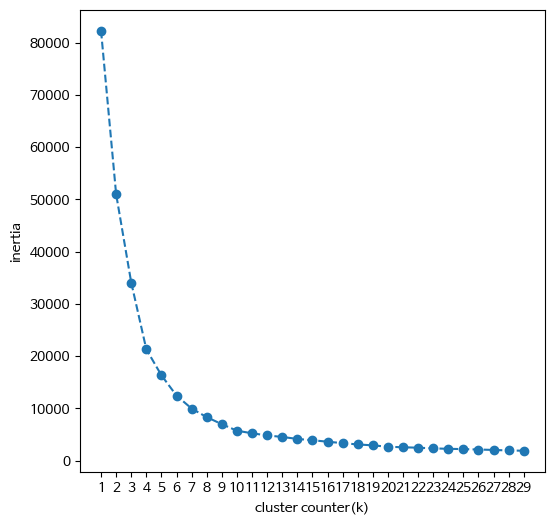

In [18]:
#클러스터 구간 찾기 눈으로 확인-최적의 클러스터 개수 찾기(엘보)
plt.figure(figsize=(6,6))
plt.plot(ks,inertias,'--o')
plt.xlabel('cluster counter(k)')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show() 

In [19]:
#기울기 계산(자동입력)-최적의 클러스터 개수 찾기(엘보)
gradients = np.gradient(inertias)
std_gradients = np.std(gradients)
threshold = 0.1 * std_gradients
diff = np.abs(np.diff(gradients))
indices = np.where(diff < threshold)[0]
if len(indices) > 0:
    idx = indices[0] + 1
    value = inertias[idx]
    print("기울기와 표준편차 값: ", value)
    print("선택된 인텍스: ", idx)
else:
    print("값을 찾지못함")

기울기와 표준편차 값:  8329.378979916506
선택된 인텍스:  7


In [20]:
#학습을 시키고 idx는 클러스터 값임.
print('n_clusters:',idx)
model=KMeans(n_clusters =idx,init = best_params[1],
                 n_init = best_params[2],max_iter = best_params[3],
                 tol = best_params[4],algorithm = best_params[5],
                 random_state = best_params[6])       
model.fit(X)
centers=model.cluster_centers_ #각 군집의 centroid
y_pred=model.predict(X)
print(y_pred)

n_clusters: 7
[6 1 1 ... 3 0 5]


In [21]:
#클러스트 값을 표,정규화
clust_df=df.copy()
clust_df['clust']=y_pred
#표준화(Standardization)
# scaler = StandardScaler()
# clust_df['clust'] = scaler.fit_transform(X)
# scaler = MinMaxScaler()
# clust_df['clust'] = scaler.fit_transform(X)
clust_df.head()                                                                                                                                   

,상세영업상태코드,사용시작지상층,의자수,좌표정보(x),좌표정보(y),날짜차이_변환,기타,네일아트업,메이크업업,미용업 기타,숙박업 기타,일반미용업,일반이용업,피부미용업,clust
231070,0.0,0.000000,0.025641,0.332382,0.811804,0.008100,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6
225828,0.0,0.043478,0.076923,0.376141,0.830047,0.515006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
263060,0.0,0.043478,0.230769,0.653626,0.637842,0.117045,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
255145,0.0,0.043478,0.076923,0.383344,0.808684,0.050767,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
97501,1.0,0.000000,0.000000,0.359600,0.740450,0.022165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [22]:
silhouette_score(X,y_pred)#실루엣 점수('1'이 좋은 점수임)(1분)

0.6737813604479083

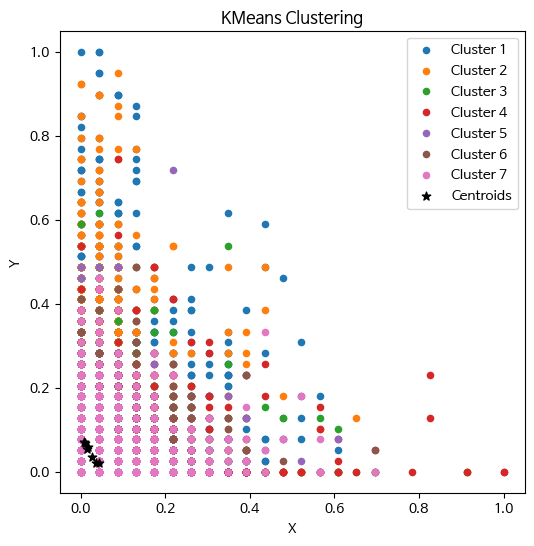

In [23]:
#시각화-'센트로이드'는 시간의 흐름을 날짜로 수치화 시켜서 크게 의미가 없음.
for i in range(model.n_clusters):
    mpl.rcParams['figure.figsize'] = (6, 6)
    plt.scatter(X[model.labels_ == i, 0], X[model.labels_ == i, 1], s = 20,
                label = 'Cluster {}'.format(i+1))
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 40,
            c = 'black', marker='*', label = 'Centroids')
plt.title('KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
#'회의'-센트로이들 기준으로 '군집'이 이루어져야하는데, 기간을 날로 변환한 
#값들의 영향력이 커서 군집이 거의 이루어 지지 못하고 약한 특성끼리 묶이게 되었습니다.
#아니면 기간총합과 좌표만으로 묶으면 좋겠다는 생각을 이글을 작성하면서 해봅니다.
#시계열 정보를 정수값으로 변환하여 사용하는것은 좋지못하다(결론)

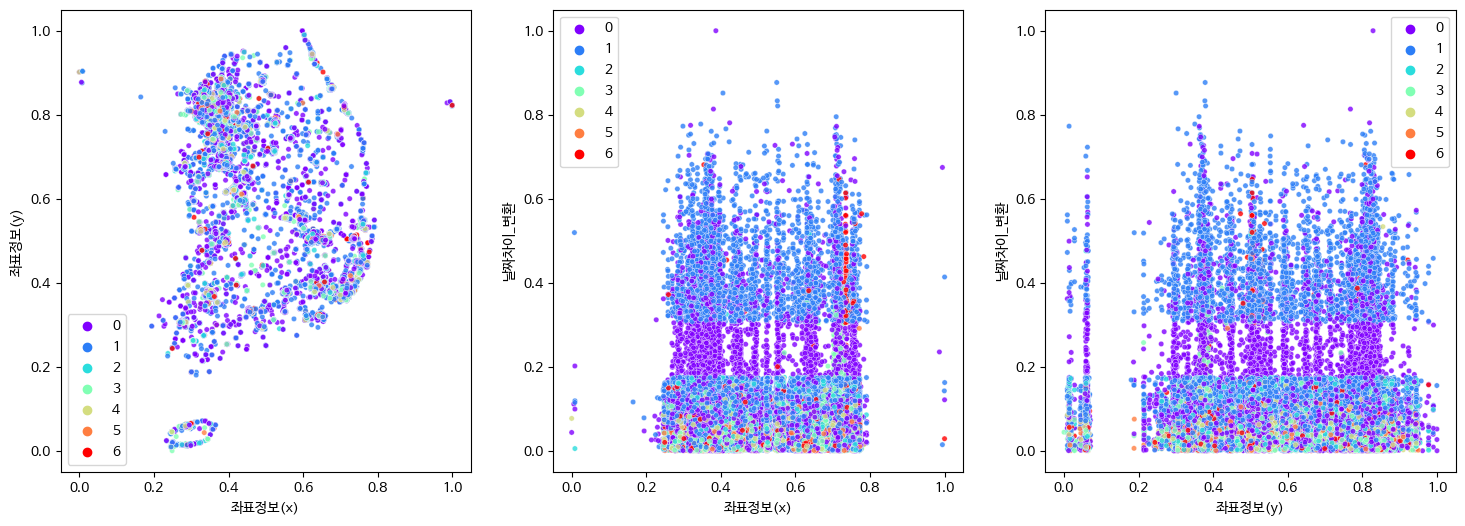

In [24]:
plt.figure(figsize=(18,6))
plt.subplot(131)
sns.scatterplot(x=clust_df.iloc[:,3],
                y=clust_df.iloc[:,4],
                data=clust_df,hue=model.labels_,alpha=0.8,s=15,
                palette='rainbow')
plt.subplot(132)
#-----------------------------------------------------------
sns.scatterplot(x=clust_df.iloc[:,3],
                y=clust_df.iloc[:,5],
                data=clust_df,hue=model.labels_,alpha=0.8,s=15,
                palette='rainbow')
plt.subplot(133)
#-----------------------------------------------------------
sns.scatterplot(x=clust_df.iloc[:,4],
                y=clust_df.iloc[:,5],
                data=clust_df,hue=model.labels_,alpha=0.8,s=15,
                palette='rainbow')
# plt.scatter(centers[:,4],centers[:,5],c='green', #각 군집의 센트로이드            
#             alpha=0.8,s=15)
plt.show()
#상세영업상태코드0,사용시작지상층1,의자수2,좌표정보(x)3,좌표정보(y)4,날짜차이_변환5
#"그래서 좌표를 불러들였습니다"

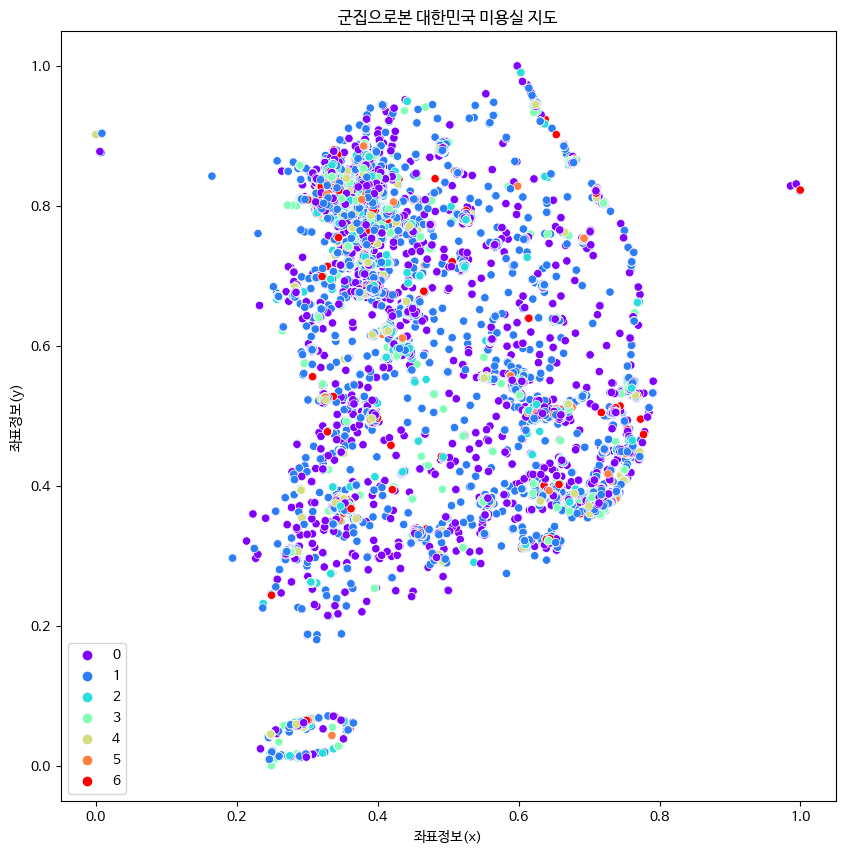

In [25]:
#좌표 형태 확대
plt.figure(figsize=(10,10))
sns.scatterplot(x=clust_df.iloc[:,3],
                y=clust_df.iloc[:,4],
                data=clust_df,hue=model.labels_,
                palette='rainbow')
plt.title('군집으로본 대한민국 미용실 지도')
plt.show()
#좌표를 기준으로 중요특성(클러스터)를 묶어보자 생각했습니다.
#아직도 묶여지고 있지는 않습니다.

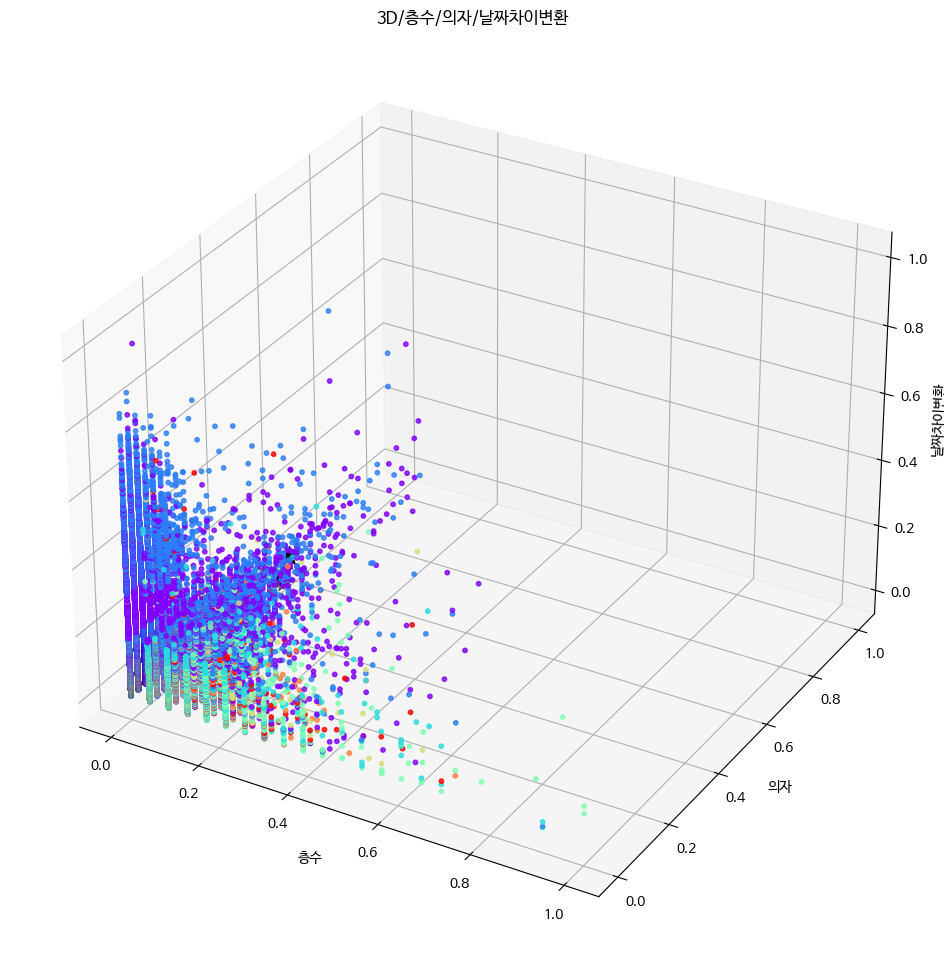

In [26]:
#3차원으로 시각화-사용시작지상층1,의자수2,날짜차이_변환5
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(clust_df.iloc[:,1],clust_df.iloc[:,2],clust_df.iloc[:,5],c=clust_df.clust,
           s=10,cmap='rainbow',alpha=0.8)
ax.scatter(centers[:,1],centers[:,2],centers[:,5],c='black',s=200,marker='*')
ax.set_title('3D/층수/의자/날짜차이변환')
ax.set_xlabel('층수')
ax.set_ylabel('의자')
ax.set_zlabel('날짜차이변환')
plt.show()

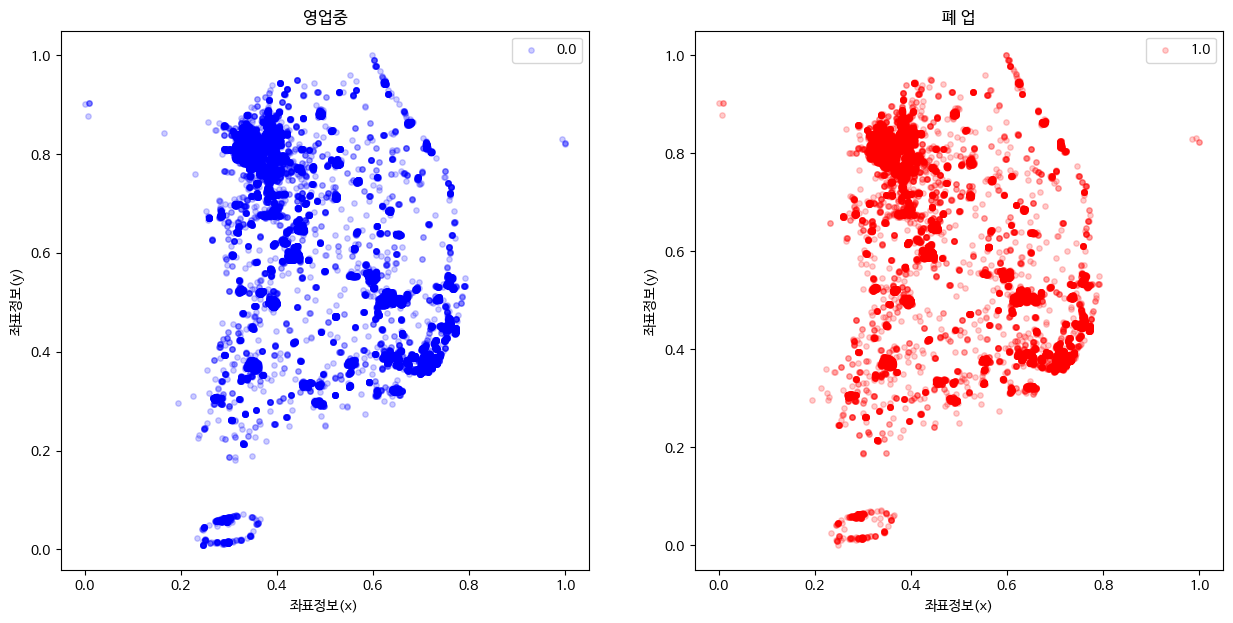

In [27]:
# 상세영업코드가 0.0인 경우와 1.0인 경우로 구분
data_0 = clust_df[clust_df['상세영업상태코드']==0.0]#영업중
data_1 = clust_df[clust_df['상세영업상태코드']==1.0]#폐업
# 그래프 사이즈 설정
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# 첫 번째 그래프 설정
axs[0].scatter(data_0['좌표정보(x)'], data_0['좌표정보(y)'], color='blue',
               label='0.0', alpha=0.2, s=15)
axs[0].set_title('영업중')
axs[0].set_xlabel('좌표정보(x)')
axs[0].set_ylabel('좌표정보(y)')
axs[0].legend()
# 두 번째 그래프 설정
axs[1].scatter(data_1['좌표정보(x)'], data_1['좌표정보(y)'], color='red',
               label='1.0', alpha=0.2, s=15)
axs[1].set_title('폐 업')
axs[1].set_xlabel('좌표정보(x)')
axs[1].set_ylabel('좌표정보(y)')
axs[1].legend()
# 그래프 출력
plt.show()

In [28]:
#그런데 한편으론 '각각의 클러스터의 특성은 어떤것일까'라는 생각이 듭니다.
#그래서 클러스터군들을 살펴봅니다.
for i in range(idx): #idx 하이퍼 파라미터 변수값
    print(f"Cluster(군집) {i}:\n")
    cluster_data = clust_df[clust_df['clust']==i]
    for col in ['상세영업상태코드', '사용시작지상층', '의자수', '좌표정보(x)',
                '좌표정보(y)', '날짜차이_변환', '기타', '네일아트업', '메이크업업',
                '미용업 기타', '숙박업 기타', '일반미용업', '일반이용업', '피부미용업']:
        print(f"{col}: {cluster_data[col].mean()}")
    print("---------------------------------\n")
#0~1사이로 정규화된 자료

Cluster(군집) 0:

상세영업상태코드: 1.0
사용시작지상층: 0.00903010977227192
의자수: 0.0679030970816393
좌표정보(x): 0.4476899453158379
좌표정보(y): 0.6634058537125622
날짜차이_변환: 0.09109277613339636
기타: 0.0
네일아트업: 0.0
메이크업업: 0.0
미용업 기타: 0.0
숙박업 기타: 0.0
일반미용업: 1.0
일반이용업: 0.0
피부미용업: 0.0
---------------------------------

Cluster(군집) 1:

상세영업상태코드: 0.0
사용시작지상층: 0.008653492746416448
의자수: 0.07076543752948528
좌표정보(x): 0.4678834158599152
좌표정보(y): 0.6347385591599264
날짜차이_변환: 0.12407577652352327
기타: 0.0
네일아트업: 0.0
메이크업업: 0.0
미용업 기타: 0.0
숙박업 기타: 0.0
일반미용업: 1.0
일반이용업: 0.0
피부미용업: 0.0
---------------------------------

Cluster(군집) 2:

상세영업상태코드: 0.0
사용시작지상층: 0.036946243190461504
의자수: 0.021164454143177545
좌표정보(x): 0.4618739385237039
좌표정보(y): 0.6290910346790345
날짜차이_변환: 0.0630786602507948
기타: 0.0
네일아트업: 0.0
메이크업업: 0.0
미용업 기타: 0.0
숙박업 기타: 0.0
일반미용업: 0.0
일반이용업: 0.0
피부미용업: 1.0
---------------------------------

Cluster(군집) 3:

상세영업상태코드: 1.0
사용시작지상층: 0.04355705102357679
의자수: 0.021896413645694106
좌표정보(x): 0.4673275122643023
좌표정보(y): 0.63

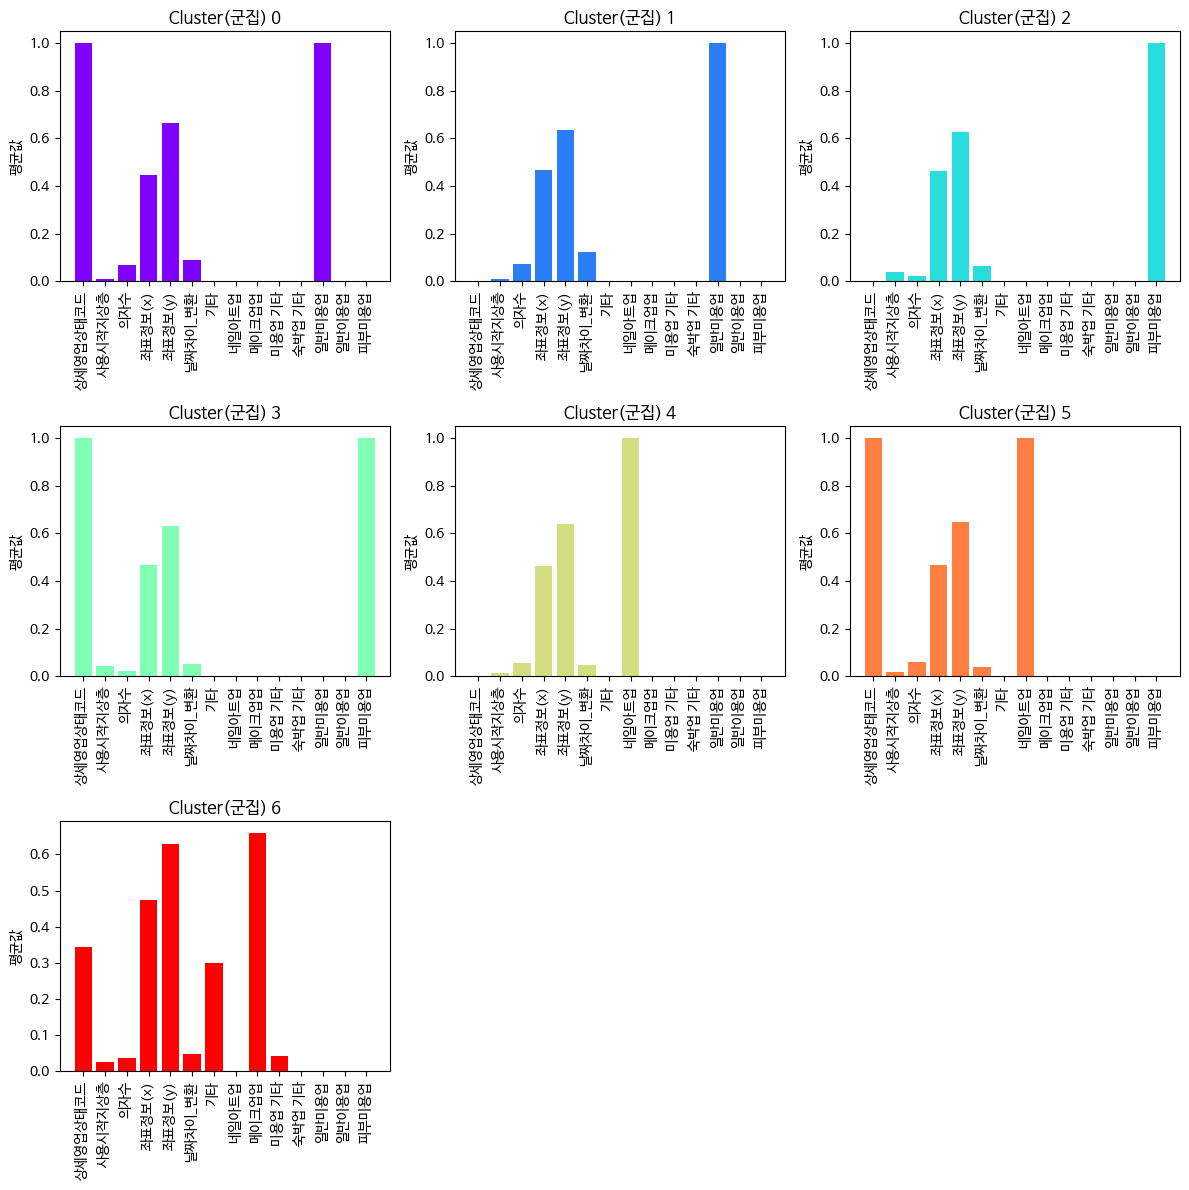

In [29]:
#각각의 클러스터군을 막대그래프로 시각화
idx = len(clust_df['clust'].unique())
n_rows = int(np.ceil(idx/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(12, 4*n_rows))
for i in range(idx):
    row = int(i/3)
    col = i%3
    cluster_data = clust_df[clust_df['clust']==i]
    for j, col_name in enumerate(['상세영업상태코드', '사용시작지상층', '의자수',
                                  '좌표정보(x)', '좌표정보(y)', '날짜차이_변환',
                                  '기타', '네일아트업', '메이크업업',
                                  '미용업 기타', '숙박업 기타', '일반미용업',
                                  '일반이용업', '피부미용업']):
        axs[row, col].bar(j, cluster_data[col_name].mean(),
                          color=plt.cm.rainbow(i/(idx-1)), label=col_name)
    axs[row, col].set_xticks(range(len(['상세영업상태코드', '사용시작지상층',
                                        '의자수', '좌표정보(x)', '좌표정보(y)',
                                        '날짜차이_변환', '기타', '네일아트업',
                                        '메이크업업', '미용업 기타',
                                        '숙박업 기타', '일반미용업',
                                        '일반이용업', '피부미용업'])))
    axs[row, col].set_xticklabels(['상세영업상태코드', '사용시작지상층',
                                   '의자수', '좌표정보(x)', '좌표정보(y)',
                                   '날짜차이_변환', '기타', '네일아트업',
                                   '메이크업업', '미용업 기타', '숙박업 기타', 
                                   '일반미용업', '일반이용업', '피부미용업'],
                                   rotation=90)
    axs[row, col].set_ylabel('평균값')
    axs[row, col].set_title(f'Cluster(군집) {i}')
    #axs[row, col].legend()
for i in range(idx, n_rows*3):
    fig.delaxes(axs[int(i/3), i%3])
plt.tight_layout()
plt.show()

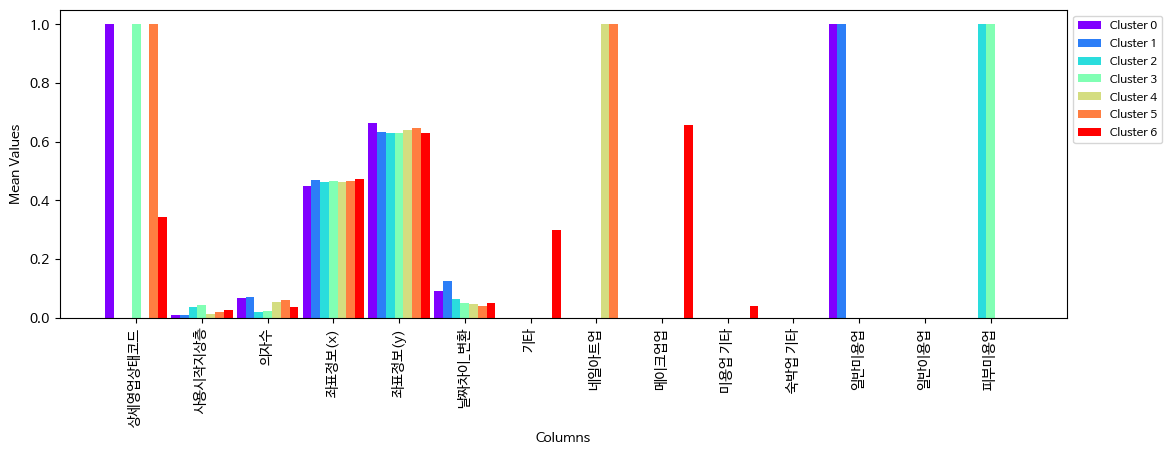

In [30]:
#각 군집별 막대그래프(통합)
cols_to_plot = ['상세영업상태코드', '사용시작지상층', '의자수', '좌표정보(x)', 
                '좌표정보(y)', '날짜차이_변환', '기타', '네일아트업',
                '메이크업업', '미용업 기타', '숙박업 기타', '일반미용업',
                '일반이용업', '피부미용업']
n_clusters = idx
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
mpl.rcParams['figure.figsize'] = (13, 4)
fig, ax = plt.subplots()
width = 1.2 / float(n_clusters + 2)
for i in range(n_clusters):
    cluster_data = clust_df[clust_df['clust']==i]
    x_values = np.arange(len(cols_to_plot)) + (i + 1) * width
    y_values = cluster_data[cols_to_plot].mean().values
    ax.bar(x_values, y_values, width=width, color=colors[i], label=f'Cluster {i}')
ax.set_xticks(np.arange(len(cols_to_plot)) + (n_clusters + 1) * width / 2)
ax.set_xticklabels(cols_to_plot, rotation=90)
ax.set_xlabel('Columns')
ax.set_ylabel('Mean Values')
ax.legend(fontsize='small', bbox_to_anchor=(1.1, 1))
plt.show()

In [31]:
#2차전-임의의 대구 좌표(대구광역시 중구 동인동4가 0304-0033 지상 1층)='대구'키워드
#주소지가 '대구'인 미용실의 좌표를 모두 가져옵니다.
#대구지역의 중요특성을 찾아서 각각클러스터와 비교합니다.
x = 0.395969
y = 0.801612
df_nearby=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fulldata_05_18_01_P_미용업.csv',
                      encoding='cp949')
df_nearby=df_nearby[['소재지전체주소','인허가일자','폐업일자','상세영업상태코드',
                     '업태구분명','사용시작지상층','의자수','좌표정보(x)',
                     '좌표정보(y)']]
df_nearby.head()

<ipython-input-31-10ca415f0164>:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nearby=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fulldata_05_18_01_P_미용업.csv',


,소재지전체주소,인허가일자,폐업일자,상세영업상태코드,업태구분명,사용시작지상층,의자수,좌표정보(x),좌표정보(y)
0,경기도 하남시 덕풍동 432-13,2022-05-17,2022-08-03,2,네일아트업,0.0,3.0,217750.864735,448205.881995
1,인천광역시 부평구 갈산동 73-16 1층 일부호,2022-05-19,2022-07-13,2,일반미용업,1.0,4.0,175829.096963,446208.270588
2,서울특별시 구로구 구로동 771-10,2022-05-19,2023-02-09,2,일반미용업,0.0,2.0,190049.611824,442823.529335
3,대전광역시 유성구 원신흥동 553-7,2022-05-23,2022-07-27,2,네일아트업,1.0,1.0,230485.827493,314852.264619
4,경기도 안산시 단원구 고잔동 771 신화타운 207호 일부,2022-05-23,2022-08-04,2,네일아트업,0.0,2.0,184933.093703,423266.254567


In [32]:
df_nearby = df_nearby.dropna()

In [33]:
df_nearby = df_nearby[df_nearby['소재지전체주소'].str.contains('대구')]
df_nearby = df_nearby[['소재지전체주소', '인허가일자', '폐업일자', 
                       '상세영업상태코드', '업태구분명', '사용시작지상층',
                       '의자수', '좌표정보(x)', '좌표정보(y)']]
df_nearby.head()

,소재지전체주소,인허가일자,폐업일자,상세영업상태코드,업태구분명,사용시작지상층,의자수,좌표정보(x),좌표정보(y)
20,대구광역시 중구 대봉동 0121-0144 2층,2022-04-27,2022-09-19,2,일반미용업,0.0,3.0,344976.836200,262868.016267
70,대구광역시 달서구 본리동 352-4 유림노르웨이아침,2022-05-03,2023-02-23,2,피부미용업,2.0,0.0,338924.266944,260828.611406
105,대구광역시 달서구 이곡동 1244-1 성서롯데시네마,2021-11-05,2022-06-30,2,네일아트업,3.0,10.0,336128.861596,262620.435474
111,대구광역시 중구 대봉동 0121-0306 1층,2022-06-21,2022-11-28,2,피부미용업,0.0,0.0,344947.217415,263092.922578
135,부산광역시 해운대구 좌동 1479-3 세종월드프라자,2022-05-25,2022-06-22,2,네일아트업,0.0,4.0,398330.516530,187771.511374


In [34]:
#군집이후 의미있는 '군집군'을 찾고, 신경망을 이용하여 특정 군집군의 분석으로 이어지는 
#과정을 표현하고 싶었습니다. 신경망으로 이어지지 못해서 아쉬움이 남았습니다.
#주제에 적합한 데이터의 선택과 그 데이터에서 중요한 특성을 찾고 추출하여 
#알맞은 처리를 하는 일련의 과정과 절차가 아주 중요하다는것을 느꼈답니다.